<a href="https://colab.research.google.com/github/pegahahadian/segmentationMRI/blob/main/SVD_brain_mri_segmentation_using_unet_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#Set Parameters
im_width = 256
im_height = 256


# **Load image's path and mask's path**

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!kaggle datasets download "mateuszbuda/lgg-mri-segmentation"

 97% 689M/714M [00:05<00:00, 97.2MB/s]
100% 714M/714M [00:05<00:00, 131MB/s] 


In [ ]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
train_files = []
mask_files = glob('/content/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_52.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_12.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_33.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_18.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_20.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_17.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_44.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_51.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_28.tif']
['/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21_mask.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_52_mask.tif', '/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_12_mask.tif', '/content/kaggle_3m/TCGA_DU_7008_1

# **Data Visualization**

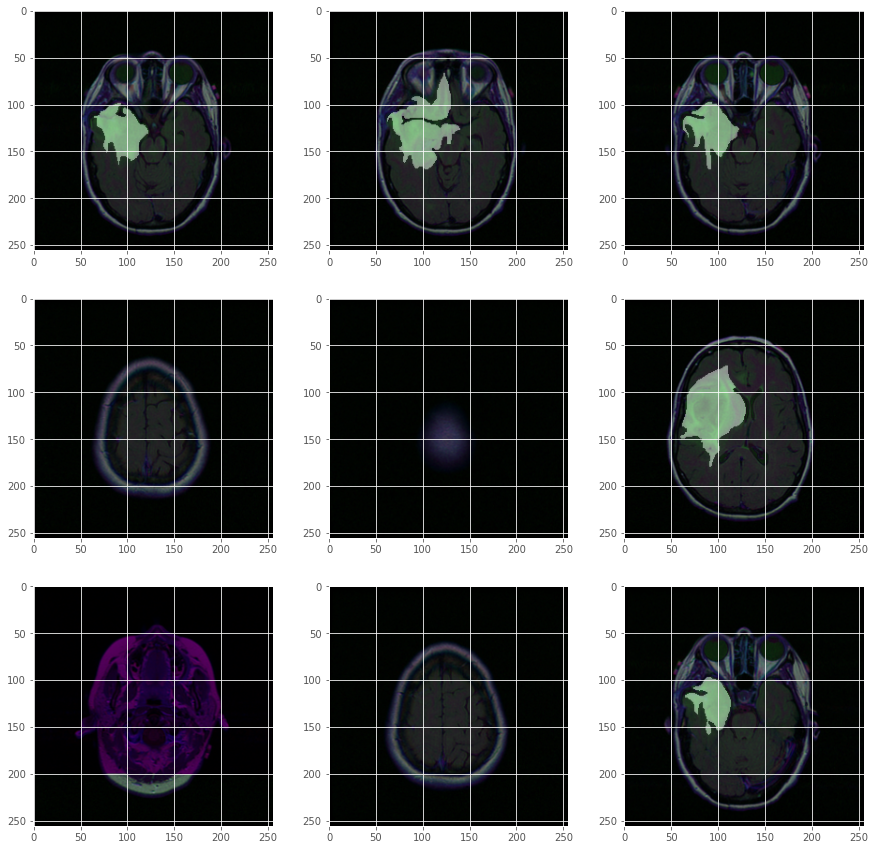

In [ ]:
#Lets plot some samples

rows,cols=3,3
fig=plt.figure(figsize=(15,15))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i+3]
    msk_path=mask_files[i+3]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
    plt.savefig('2.png')
plt.show()

SVD

In [ ]:
# Import the necessary libraries
from PIL import Image
from numpy import asarray
import cv2
rgb_weights = [0.2989, 0.5870, 0.1140]

df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
gray_image = list(map(lambda x: np.dot(cv2.imread(x)[...,:3], rgb_weights), list(df.filename)))

In [ ]:
df.head(9)


,filename,mask
0,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
1,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
2,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
3,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
4,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
5,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
6,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
7,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...
8,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...


In [ ]:
df.filename.iloc[2]

'/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_12.tif'

In [ ]:
df.filename.iloc[300]

'/content/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_55.tif'

In [ ]:
df.insert(2, "N_filename",  True)

In [ ]:
def denoise(m):
    A=np.dot(cv2.imread(m)[...,:3], rgb_weights)
    #A=m
    A1= np.reshape(A, (4, 16384)) 
    U, s, v= np.linalg.svd(A1, full_matrices=False)
    T=(U.transpose()).dot(A1)
    T1=np.reshape(T[0,:], (128,128))
    T2=np.reshape(T[1,:], (128,128)) 
    T3=np.reshape(T[2,:], (128,128)) 
    T4=np.reshape(T[3,:], (128,128)) 
    TT1=np.reshape(T1, (1,16384))
    TT2=np.reshape(T2, (1,16384))
    TT3=np.reshape(T3, (1,16384))
    TT4=np.reshape(T4, (1,16384))
    T2=np.concatenate((TT1,TT2))
    T2=np.concatenate((T2,TT3))
    T2=np.concatenate((T2,TT4))
    A2= U.dot(T2)
    AA=np.reshape(A2, (256, 256)) 
    return AA
#U, s, V = np.linalg.svd(m, full_matrices=False)

In [ ]:
img = list(map(lambda x: denoise(x), list(df.filename)))

In [ ]:
import matplotlib
from matplotlib import cm
for i in range(0,3929):
  a=img[i]
  b='/content/kaggle_3m/'+str(i)+'.jpg'
  df['N_filename'].iloc[i]=b
  matplotlib.image.imsave(b,a, cmap = cm.gray)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df.head(9)


,filename,mask,N_filename
0,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/0.jpg
1,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/1.jpg
2,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/2.jpg
3,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/3.jpg
4,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/4.jpg
5,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/5.jpg
6,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/6.jpg
7,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/7.jpg
8,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/TCGA_DU_7008_19830723/TCGA_...,/content/kaggle_3m/8.jpg


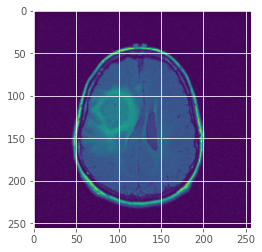

In [ ]:

rgb_weights = [0.2989, 0.5870, 0.1140]
img = np.dot(cv2.imread(df.filename.iloc[3])[...,:3], rgb_weights)
plt.imshow(img)

In [ ]:
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt

USVs = np.linalg.svd(img, full_matrices=False)

In [ ]:
u,s,v = USVs
u.shape

(256, 256)

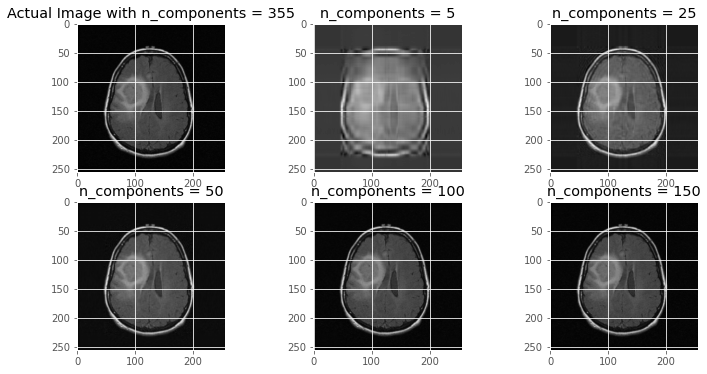

In [ ]:
comps = [355, 5,25,50,100,150]
plt.figure(figsize=(12, 6))

for i in range(len(comps)):
	low_rank = u[:, :comps[i]] @ np.diag(s[:comps[i]]) @ v[:comps[i], :]
	
	if(i == 0):
		plt.subplot(2, 3, i+1),
		plt.imshow(low_rank, cmap='gray'),
		plt.title(f'Actual Image with n_components = {comps[i]}')
		plt.savefig('2.png')
	
	else:
		plt.subplot(2, 3, i+1),
		plt.imshow(low_rank, cmap='gray'),
		plt.title(f'n_components = {comps[i]}')
		plt.savefig('svd.png')


# **Create data frame and split data on train set, validation set and test set**

In [ ]:
df2 = pd.DataFrame(data={"N_filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df2,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


# **Data genertator, data augmentation and adjust data**

In [ ]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "N_filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 150
    mask = mask / 150
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# **Define loss function and metrics**

In [ ]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# **Define Unet**

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model2 = unet()
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

# **Training**

In [ ]:
EPOCHS = 70
BATCH_SIZE = 32
learning_rate = 1e-4

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/70
89/88 [==============================] - ETA: 0s - loss: -0.0964 - binary_accuracy: 0.8810 - iou: 0.0516 - dice_coef: 0.0968Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02519, saving model to unet_brain_mri_seg.hdf5
88/88 [==============================] - 154s 2s/step - loss: -0.0964 - binary_accuracy: 0.8810 - iou: 0.0516 - dice_coef: 0.0968 - val_loss: -0.0252 - val_binary_accuracy: 0.9817 - val_iou: 0.0128 - val_dice_coef: 0.0251
Epoch 2/70
89/88 [==============================] - ETA: 0s - loss: -0.1633 - binary_accuracy: 0.9833 - iou: 0.0905 - dice_coef: 0.1642
Epoch 2: val_loss did not improve from -0.02519
88/88 [==============================] - 150s 2s/step - loss: -0.1633 - binary_accuracy: 0.9833 - iou: 0.0905 - dice_coef: 0.1642 - val_loss: -0.0228 - val_binary_accuracy: 0.9888 - val_iou: 0.0117 - val_dice_coef: 0.02

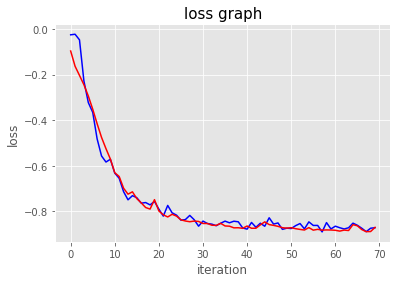

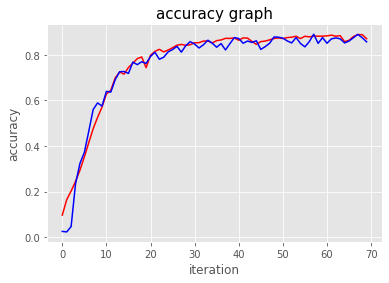

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [ ]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 12s 998ms/step - loss: -0.8948 - binary_accuracy: 0.9981 - iou: 0.8116 - dice_coef: 0.8946
Test lost:  -0.8947637677192688
Test IOU:  0.9981217384338379
Test Dice Coefficent:  0.8115780353546143


In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['N_filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(img))
    plt.imshow(np.squeeze(pred)>.5,alpha=0.4)
    plt.title('Image with prediction mask')
    plt.savefig('M2.eps',bbox_inches='tight', format='eps')
    plt.show()

KeyError: ignored